# Stock Buying/Learning
## Using Reinforcement Training

### What is this?
This is a Python program that implements a reinforcement learning-based algorithmic trading strategy. It utilizes historical market data to train and evaluate a trading agent, which learns to make buy/sell decisions based on the current market conditions.

### What does this do exactly?
It collects historical market data for a set of assets (e.g., stocks, cryptocurrencies). In this case, it's from the S&P 500. It then preprocess the data to remove outliers, handle missing values, and formats it into suitable input for the reinforcement learning model. 
Afterwhich, it implements a reinforcement learning algorithm (e.g., Q-learning, Deep Q-Networks) to learn trading strategies. 

This journal will implement: the state space, the action space, and the reward structure for the trading agent. And will train the reinforcement learning model using the preprocessed historical data obtained from yfinance.

Afterwards, the data will be evaluated to deterimine the performance of the trained trading agent using a separate testing dataset. 

It'll use backtesting to assess the profitability and risk-adjusted returns of the trading strategy. 
Finally it'll compare the performance of the reinforcement learning-based strategy with baseline strategies (e.g., buy-and-hold) and visualize the data.

## Libraries Needed:
```
pip install yfinance
pip install pandas
pip install numpy
pip install matplotlib
```

## Step 1: Import The Libraries Needed...

In [ ]:
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings

## Step 2: Obtain Data
The data is based on the past 5 years worth of data.

In [1]:
# Ignore SettingWithCopyWarning warnings
warnings.filterwarnings('ignore', category=pd.core.generic.SettingWithCopyWarning)

# Let's get the data for S&P500...
end_date = datetime.today().strftime('%Y-%m-%d')

# 5 years is 5 years * 12 months * 30 days (roughly)
start_date = (datetime.today() - timedelta(days=5*12*30)).strftime('%Y-%m-%d')

# Fetch data for SPY ticker
spy_data = yf.download('SPY', start=start_date, end=end_date)
    
# Drop rows with NA values
spy_data = spy_data.dropna()

# Let's make spy_data as df for easier code, but later we can reference our spy_data set 
df = spy_data

# Let's sort by Date ascending...
df = df.sort_values(by='Date', ascending=True)
df.head(5)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-04-29,293.510010,294.450012,293.410004,293.869995,271.171021,57197700
2019-04-30,293.489990,294.339996,291.920013,294.019989,271.309509,81111700
2019-05-01,294.720001,294.950012,291.799988,291.809998,269.270142,71671900
2019-05-02,291.679993,292.700012,289.519989,291.179993,268.688843,65030200
2019-05-03,292.820007,294.339996,291.299988,294.029999,271.318695,56543700


## Step 3: Review The Data
Let's take a look at the data and analyze it's skewness and kurtosis info.

In [2]:
# Getting statistics doesn't work because the date isn't a part of the same axis when pulled.
stat_df = df
stat_df['Date'] = stat_df.index
statistics = stat_df.drop(columns=['Date']).describe()
print("Statistics:")
print(statistics)

# Print "skewness" and "kurtosis" for numerical columns...
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
skewness = df[numerical_columns].skew()
kurtosis = df[numerical_columns].kurtosis()

print("\nSkewness:")
print(skewness)

print("\nKurtosis:")
print(kurtosis)

Statistics:
              Open         High          Low        Close    Adj Close  \
count  1239.000000  1239.000000  1239.000000  1239.000000  1239.000000   
mean    387.149072   389.544996   384.621509   387.251752   373.690164   
std      63.294245    63.234673    63.334966    63.336969    67.609159   
min     228.190002   229.679993   218.259995   222.949997   209.932617   
25%     329.950012   332.175003   327.539993   330.020004   310.498886   
50%     397.230011   400.179993   393.690002   397.369995   388.391846   
75%     437.244995   439.985001   434.750000   437.214996   425.788147   
max     523.390015   524.609985   522.780029   523.169983   523.169983   

             Volume  
count  1.239000e+03  
mean   8.418209e+07  
std    4.112333e+07  
min    2.027000e+07  
25%    5.902070e+07  
50%    7.540580e+07  
75%    9.589530e+07  
max    3.922207e+08  

Skewness:
Open        -0.257942
High        -0.258111
Low         -0.255752
Close       -0.255893
Adj Close   -0.229517
Vo

## Step 4: Create Datasets
Let's split the data into training and testing dataframes...

In [3]:
train_size = 0.8
train_len = int(df.shape[0] * train_size)

if train_len > 0:
    train_df = df.iloc[:train_len, :]
    test_df = df.iloc[train_len:, :]
else:
    print("ERROR IN CREATING TRAINING DATA!")

In [4]:
# Check that our train data looks good
train_df.head()

,Open,High,Low,Close,Adj Close,Volume,Date
Date,,,,,,,
2019-04-29,293.510010,294.450012,293.410004,293.869995,271.171021,57197700,2019-04-29
2019-04-30,293.489990,294.339996,291.920013,294.019989,271.309509,81111700,2019-04-30
2019-05-01,294.720001,294.950012,291.799988,291.809998,269.270142,71671900,2019-05-01
2019-05-02,291.679993,292.700012,289.519989,291.179993,268.688843,65030200,2019-05-02
2019-05-03,292.820007,294.339996,291.299988,294.029999,271.318695,56543700,2019-05-03


## Step 5: Defining some methods...
Let's create some methods we'll use for the training

In [5]:
# We're going to use bollinger bands to help do our training..
# More info: https://www.investopedia.com/terms/b/bollingerbands.asp
def get_bollinger_bands(values, window):
    # Rolling mean
    rm = values.rolling(window=window).mean()
    rstd = values.rolling(window=window).std()
    
    band_width = 2. * rstd / rm
    return band_width.apply(lambda x: round(x, 5))

# Returns adjusted closing value vs simple moving average for a given sliding window of time
def get_adj_close_sma_ratio(values, window):
    rm = values.rolling(window=window).mean()
    ratio = values / rm
    return ratio.apply(lambda x: round(x, 5))

# Used to convert continuous values to integer
def discretize(values, num_states=10):
    states_value = dict()
    step_size = 1. / num_states
    for i in range(num_states):
        if i == num_states - 1:
            states_value[i] = values.max()
        else:
            states_value[i] = values.quantile((i+1) * step_size)
    return states_value

# Convert Values to State
def value_to_state(value, states_value):
    if np.isnan(value):
        return np.nan
    else:
        for state, v in states_value.items():
            if value <= v:
                return str(state)
        return 'value out of range'

# Create a normalized df
def create_df(df, window=3):
    # First, we need to get bollinger value...
    bb_width = get_bollinger_bands(df['Adj Close'], window)

    # Then we need to get the ratio of close price to simple moving average
    close_sma_ratio = get_adj_close_sma_ratio(df['Close'], window)
    
    # Let's add the columns to our df...
    df['bb_width'] = bb_width
    df['close_sma_ratio'] = close_sma_ratio
    
    # Drop missing values, and perform the actual df copy
    df = df.dropna().copy()
    
    # Now to normalize the closing price and add those columns to our copied df
    df['norm_adj_close'] = df['Adj Close'] / df['Adj Close'].iloc[0]
    df['norm_bb_width'] = df['bb_width'] / df['bb_width'].iloc[0]
    df['norm_close_sma_ratio'] = df['close_sma_ratio'] / df['close_sma_ratio'].iloc[0]
    
    # Return the newly created (copied) df
    return df

# Used for getting state values of price states, bb states, and close_sma_ratio states
def get_states(df):
    # Discretize values
    price_states_value = discretize(df['norm_adj_close'])
    bb_states_value = discretize(df['norm_bb_width'])
    close_sma_ratio_states_value = discretize(df['norm_close_sma_ratio'])
    
    return price_states_value, bb_states_value, close_sma_ratio_states_value

# Create a state column for our df...
def create_state_df(df, price_states_value, bb_states_value, close_sma_ratio_states_value):
    df.loc[:, 'bb_width_state'] = df['bb_width'].apply(lambda x : value_to_state(x, bb_states_value))
    df.loc[:, 'close_sma_ratio_state'] = df['close_sma_ratio'].apply(lambda x : value_to_state(x, close_sma_ratio_states_value))
    df.loc[:, 'norm_adj_close_state'] = df['norm_adj_close'].apply(lambda x : value_to_state(x, price_states_value))
    
    # Create the final state by combining our normalized values into state values
    df.loc[:, 'state'] = df['norm_adj_close_state'] + df['close_sma_ratio_state'] + df['bb_width_state']
    
    # Create a copy and return it
    df = df.dropna().copy()
    return df

# Generate a list of all the states as a list of strings
def get_all_states(price_states_value, bb_states_value, close_sma_ratio_states_value):
    # Empty List
    states = []

    # For every price state (values)...
    for p, _ in price_states_value.items():
        # For every close_sma_ratio_states_value...
        for c, _ in close_sma_ratio_states_value.items():
            # For every bb_states_value...
            for b, _ in bb_states_value.items():
                # Create a string of a state that is:
                # price (p) + close (c) + bb_states (b)
                state =  str(p) + str(c) + str(b)
                # Add it to the list
                states.append(str(state))
    
    return states


In [6]:
# Let's take a look at our new training set now with all the extra data added
train_df.head(5)

,Open,High,Low,Close,Adj Close,Volume,Date
Date,,,,,,,
2019-04-29,293.510010,294.450012,293.410004,293.869995,271.171021,57197700,2019-04-29
2019-04-30,293.489990,294.339996,291.920013,294.019989,271.309509,81111700,2019-04-30
2019-05-01,294.720001,294.950012,291.799988,291.809998,269.270142,71671900,2019-05-01
2019-05-02,291.679993,292.700012,289.519989,291.179993,268.688843,65030200,2019-05-02
2019-05-03,292.820007,294.339996,291.299988,294.029999,271.318695,56543700,2019-05-03


## Step 6: Define Details
We'll need to define some details, such as available actions, create states, etc.

In [7]:
# Now let's define some details...

# First is our actions of hold
all_available_actions = {0:'hold', 1:'buy', 2:'sell'}

# Let's create a new df for our training dataframe, with a window of 3
train_df = create_df(train_df, 3)

# Let's get our states of our train_df
price_states_value, bb_states_value, close_sma_ratio_states_value = get_states(train_df)

# Now let's create our new train_df that now also has our price states, bb states, and close sma ratio states...
train_df = create_state_df(train_df, price_states_value, bb_states_value, close_sma_ratio_states_value)

# And let's get all of the states and store it
all_states = get_all_states(price_states_value, bb_states_value, close_sma_ratio_states_value)
states_size = len(all_states)
print(f"Number of states: {states_size}")

Number of states: 1000


In [8]:
# Let's take a look at our train_df now...
train_df.head(5)

,Open,High,Low,Close,Adj Close,Volume,Date,bb_width,close_sma_ratio,norm_adj_close,norm_bb_width,norm_close_sma_ratio,bb_width_state,close_sma_ratio_state,norm_adj_close_state,state
Date,,,,,,,,,,,,,,,,
2019-05-01,294.720001,294.950012,291.799988,291.809998,269.270142,71671900,2019-05-01,0.00842,0.99515,1.000000,1.000000,1.000000,0,1,0,010
2019-05-02,291.679993,292.700012,289.519989,291.179993,268.688843,65030200,2019-05-02,0.01020,0.99604,0.997841,1.211401,1.000894,0,1,0,010
2019-05-03,292.820007,294.339996,291.299988,294.029999,271.318695,56543700,2019-05-03,0.01024,1.00578,1.007608,1.216152,1.010682,0,4,1,140
2019-05-06,289.250000,293.309998,288.899994,292.820007,270.202118,107198100,2019-05-06,0.00977,1.00049,1.003461,1.160333,1.005366,0,2,0,020
2019-05-07,290.149994,290.809998,285.809998,287.929993,265.689850,144729900,2019-05-07,0.02215,0.98744,0.986704,2.630641,0.992252,0,0,0,000


## Step 7: Test Dataframe Creation
Let's actually create the dataframes we need for testing...

In [9]:
# Now let's process our test_df

# Create a copy with a window of 3
test_df = create_df(test_df, 3)

# Create a copy with our price states, bb states and close sma ratio states...
test_df = create_state_df(test_df, price_states_value, bb_states_value, close_sma_ratio_states_value)

## Step 8: Define Q-Learning Methods
# Now let's define our methods we'll be using for the Q-Learning...

### Our helper and init sorta methods:
* def initialize_q_mat(all_states, all_available_actions):
* def act(state, q_mat, threshold=0.2, actions_size=3):
* def get_return_since_entry(bought_history, current_adj_close):
* def visualize_results(actions_history, returns_since_entry):
* def get_invested_capital(actions_history, returns_since_entry):
* def get_base_return(data):

### Our actual learning methods:
* def train_q_learning(train_data, q, alpha, gamma, episodes):
* def eval_q_learning(test_data, q):

In [10]:

# Create a randomly initialized Q-table for use.
# Based on our states and all available actions:
def initialize_q_mat(all_states, all_available_actions):

    # Get the lengths
    states_size = len(all_states)
    actions_size = len(all_available_actions)

    # Randomize
    q_mat = np.random.rand(states_size, actions_size)/1e9
    q_mat = pd.DataFrame(q_mat, columns=all_available_actions.keys())
    
    # Setup the df with the new states
    q_mat['states'] = all_states
    # Fix the axis issue
    q_mat.set_index('states', inplace=True)
    
    # Return it
    return q_mat

# Take an action method
def act(state, q_mat, threshold=0.2, actions_size=3):
    # Either do something random... or the action with the highest return
    if np.random.uniform(0,1) < threshold:
        # Do a random action
        action = np.random.randint(low=0, high=actions_size)  
    else:
        # Do the action with the highest return
        action = np.argmax(q_mat.loc[state].values)
    
    # Report back what action was done
    return action

# Calcualte the current returns...
def get_return_since_entry(bought_history, current_adj_close):
    return_since_entry = 0.
    
    # perform a simple sumation...
    for b in bought_history:
        return_since_entry += (current_adj_close - b)
    return return_since_entry

# Visualize with the upper plot showing return since entry
# And lower show the actual signal plot
def visualize_results(actions_history, returns_since_entry):
    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,12))
    
    # Upper Plot...
    ax1.plot(returns_since_entry)
    
    days, prices, actions = [], [], []
    for d, p, a in actions_history:
        days.append(d)
        prices.append(p)
        actions.append(a)

    # Lower Plot...
    ax2.plot(days, prices, label='Normalized Adj. Close Price')
    hold_d, hold_p, buy_d, buy_p, sell_d, sell_p = [], [], [], [], [], []
    for d, p, a in actions_history:
        if a == 0:
            hold_d.append(d)
            hold_p.append(p)
        if a == 1:
            buy_d.append(d)
            buy_p.append(p)
        if a == 2:
            sell_d.append(d)
            sell_p.append(p)

    ax2.scatter(hold_d, hold_p, color='blue', label='HOLD')
    ax2.scatter(buy_d, buy_p, color='green', label='BUY')
    ax2.scatter(sell_d, sell_p, color='red', label='SELL')
    ax2.legend()

# Calculate the maximum capital investment ratio
def get_invested_capital(actions_history, returns_since_entry):
    invest = []
    total = 0
    return_invest_ratio = None
    for i in range(len(actions_history)):
        a = actions_history[i][2]
        p = actions_history[i][1]

        try:
            next_a = actions_history[i+1][2]
        except:
            #print('DONE')
            break
        if a == 1:
            total += p
            #print(f"Total: {total}")
            if next_a != 1 or (i==len(actions_history)-2 and next_a==1):
                invest.append(total)
                total = 0
    if invest:
        return_invest_ratio = returns_since_entry[-1]/max(invest)
        print('Invested Capital {}, Return/Invest Ratio {}'.format(max(invest), return_invest_ratio))
    else:
        print('No BUY Transactions -- INVALID TRAINING!')
    return return_invest_ratio

# Just grab the return benchmark
def get_base_return(data):
    start_price, _ = data[0]
    end_price, _ = data[-1]
    return (end_price - start_price)/start_price

# The fun part, the Q-Training!
# This code will do the training
# q is the initial Q-Table needed
# alpha is the threshold of which action strat to take.
# gamma is the discount percentage on the future turn
# The result will be a list of every day's return since the entry
def train_q_learning(train_data, q, alpha, gamma, episodes):
    # Initilize...
    actions_history = []
    num_shares = 0
    bought_history = []
    returns_since_entry = [0]


    for _ in range(episodes):
        actions_history = []
        num_shares = 0
        bought_history = []
        returns_since_entry = [0]

        for i, val in enumerate(train_data):
            current_adj_close, state = val
            try:
                next_adj_close, next_state = train_data[i+1]
            except:
                break

            if len(bought_history) > 0:
                returns_since_entry.append(get_return_since_entry(bought_history, current_adj_close)) 
            else:
                returns_since_entry.append(returns_since_entry[-1])

            # Decide the action...
            if alpha > 0.1:
                alpha = alpha/(i+1)
            action = act(state, q, threshold=alpha, actions_size=3)

            # Get Reward
            if action == 0: 
                # HOLD ACTION
                if num_shares > 0:
                    prev_adj_close, _ = train_data[i-1]
                    # future = next_adj_close - current_adj_close 
                    past = current_adj_close - prev_adj_close
                    reward = past
                else:
                    reward = 0

            if action == 1: 
                # BUY ACTION
                reward = 0
                num_shares += 1
                bought_history.append((current_adj_close))       

            if action == 2: 
                # SELL ACTION
                if num_shares > 0:
                    bought_price = bought_history[0]
                    reward = (current_adj_close - bought_price)
                    bought_history.pop(0)
                    num_shares -= 1
                else:
                    reward = -100
            
            # Add it to the action history...        
            actions_history.append((i, current_adj_close, action))
            
            # Update the Q-Table
            q.loc[state, action] = (1.-alpha)*q.loc[state, action] + alpha*(reward+gamma*(q.loc[next_state].max()))
    
    print('TRAINING DONE!')
    # Return the results...
    return q, actions_history, returns_since_entry

# Evaluate the Q-Table...
def eval_q_learning(test_data, q):
    # Initilize...
    actions_history = []
    num_shares = 0
    returns_since_entry = [0]
    bought_history = []
    

    for i, val in enumerate(test_data):
        current_adj_close, state = val
        try:
            next_adj_close, next_state = test_data[i+1]
        except:
            print('DONE!')
            break   

        if len(bought_history) > 0:
            returns_since_entry.append(get_return_since_entry(bought_history, current_adj_close)) 
        else:
            returns_since_entry.append(returns_since_entry[-1])

        # Decide the action...
        action = act(state, q, threshold=0, actions_size=3)

        if action == 1: 
            # BUY ACTION
            num_shares += 1
            bought_history.append((current_adj_close))
        if action == 2: 
            # SELL ACTION
            if num_shares > 0:
                bought_price = bought_history[0]
                bought_history.pop(0)
                num_shares -= 1
        
        # Add it to the action history...        
        actions_history.append((i, current_adj_close, action))
    
    print('EVALUATION DONE!')
    # Return the results...
    return actions_history, returns_since_entry


In [11]:
train_df.head()

,Open,High,Low,Close,Adj Close,Volume,Date,bb_width,close_sma_ratio,norm_adj_close,norm_bb_width,norm_close_sma_ratio,bb_width_state,close_sma_ratio_state,norm_adj_close_state,state
Date,,,,,,,,,,,,,,,,
2019-05-01,294.720001,294.950012,291.799988,291.809998,269.270142,71671900,2019-05-01,0.00842,0.99515,1.000000,1.000000,1.000000,0,1,0,010
2019-05-02,291.679993,292.700012,289.519989,291.179993,268.688843,65030200,2019-05-02,0.01020,0.99604,0.997841,1.211401,1.000894,0,1,0,010
2019-05-03,292.820007,294.339996,291.299988,294.029999,271.318695,56543700,2019-05-03,0.01024,1.00578,1.007608,1.216152,1.010682,0,4,1,140
2019-05-06,289.250000,293.309998,288.899994,292.820007,270.202118,107198100,2019-05-06,0.00977,1.00049,1.003461,1.160333,1.005366,0,2,0,020
2019-05-07,290.149994,290.809998,285.809998,287.929993,265.689850,144729900,2019-05-07,0.02215,0.98744,0.986704,2.630641,0.992252,0,0,0,000


## Step 9: Getting Training Ready...

In [12]:
# Let's get our training ready...
np.random.seed(42)
q = initialize_q_mat(all_states, all_available_actions)/1e9
print('Initializing q....')
print(q[:3])

Initializing q....
                   0             1             2
states                                          
000     3.745401e-19  9.507143e-19  7.319939e-19
001     5.986585e-19  1.560186e-19  1.559945e-19
002     5.808361e-20  8.661761e-19  6.011150e-19


In [13]:
# Setup our train data to rely on norm_adj_close and state data...
train_data = np.array(train_df[['norm_adj_close', 'state']])

print("STARTING: training...")
q, train_actions_history, train_returns_since_entry = train_q_learning(train_data, q, alpha=0.8, gamma=0.95, episodes=1)

STARTING: training...
TRAINING DONE!


## Step 10: Visualize The Results
Let's visualize the trading decisions made by the agent over time. 
This will help us analyze the cumulative returns, Sharpe ratio, maximum drawdown, and other relevant metrics as well as provide insights into the strengths and weaknesses of the developed trading strategy.

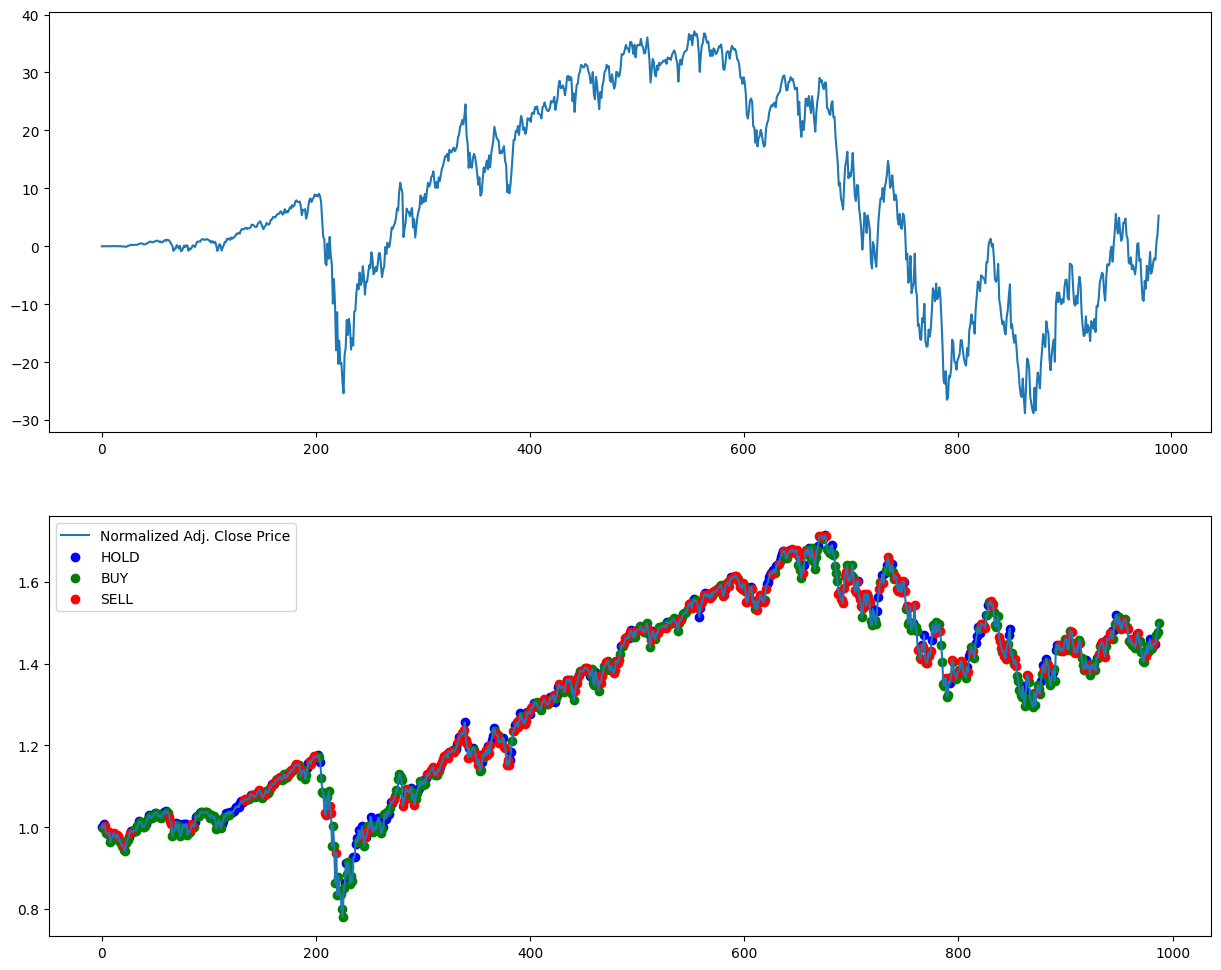

In [14]:
visualize_results(train_actions_history, train_returns_since_entry)

In [15]:
# Let's get some details...
get_invested_capital(train_actions_history, train_returns_since_entry)
print('Base Return/Investment Ratio: {}'.format(get_base_return(train_data)))

Invested Capital 15.388720776150446, Return/Invest Ratio 0.34343262893014054
Base Return/Investment Ratio: 0.5043775423746102


In [16]:
# Now let's do an evaluation of our training using our test data...
test_data = np.array(test_df[['norm_adj_close', 'state']])
test_actions_history, test_returns_since_entry = eval_q_learning(test_data, q)

DONE!
EVALUATION DONE!


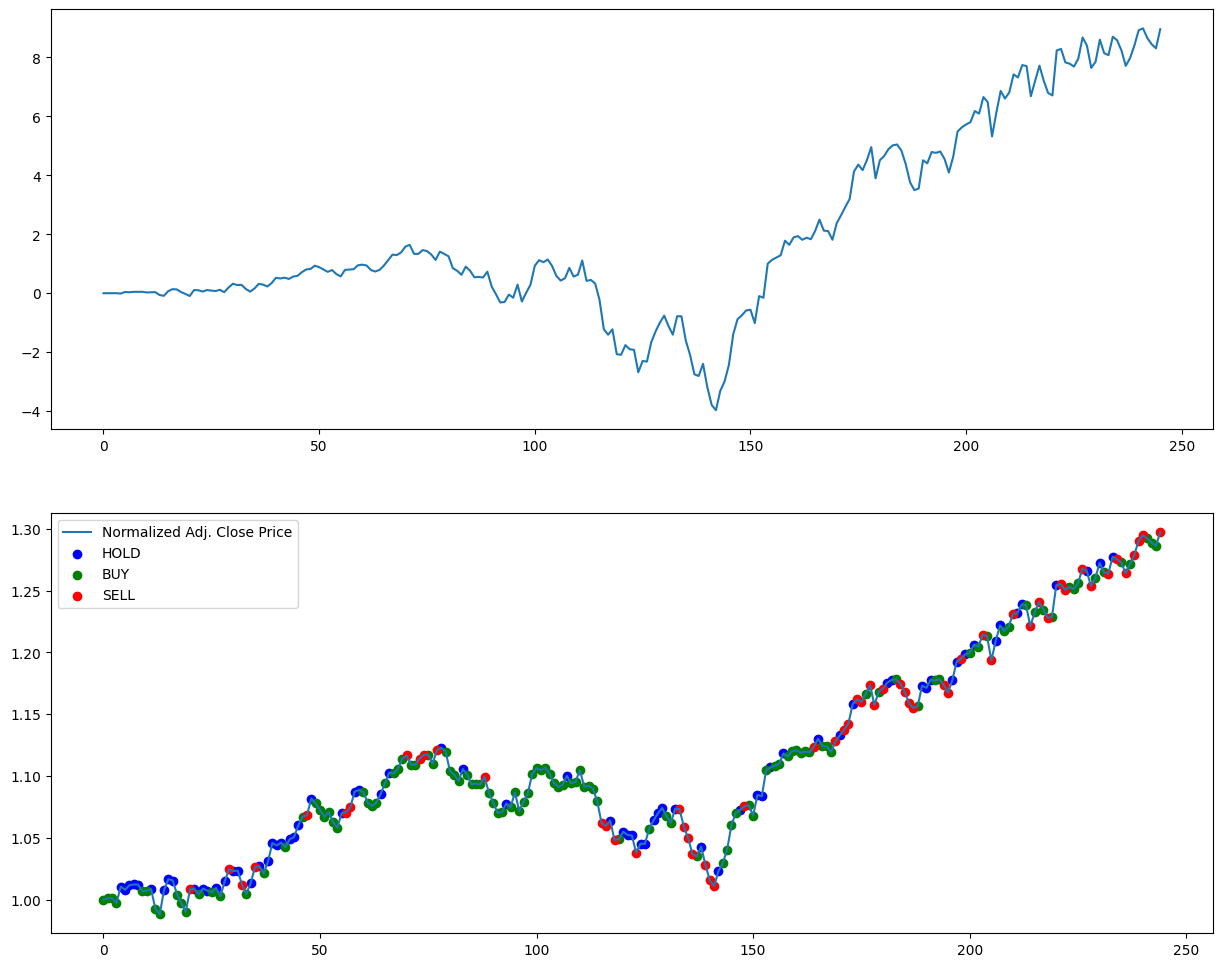

In [17]:
# Again, let's check out the visulizatino of our evaluation (of the test data...)
visualize_results(test_actions_history, test_returns_since_entry)

## Step 11: The Final Results

In [18]:
# Display the details:
get_invested_capital(test_actions_history, test_returns_since_entry)
print('Base Return/Investment Ratio: {}'.format(get_base_return(test_data)))

Invested Capital 14.198395982852613, Return/Invest Ratio 0.6310284056065372
Base Return/Investment Ratio: 0.29681731952953405
